<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
import numpy as np


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        print("shape param ", param.shape)
        print("dim ", n)
        print(S_inv.shape)
        print("S_inv ", S_inv)
        partial = S_inv @ param  # should be (m * n,)
        if S_inv.shape == (n, n):
          print("S_inv (n, n)")
          param_norm = cp.pnorm(partial, p=q)
        else:  # should be a stack of matrix
          print("S_inv conc")
          print("shape partial 1", partial.shape)
          partial = cp.reshape(partial, (m, n), order='C')
          print("shape partial ", partial.shape)
          param_norm = cp.pnorm(partial, p=q, axis=1)
        print("param_norm.shape", param_norm.shape)
        print("param_norm\n", param_norm)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        print("ciao2")
        abs_error = cp.abs(X @ param - y)
        print("abs_error.shape ", abs_error.shape)
        print("ciao3")
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        print("ciao4")
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        #print("alpha  ", a)
        coefs = estimator(X, y, a)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    #print("coef ", coefs)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data


#M = np.sum(masks, axis=1)
#X_nan = X.copy()
#X_nan[masks == 1] = np.nan

#X = multiple_imputation(1, X_nan)
print("end block")


end block


In [37]:
# imputation's block

def clear_dataset(x, masks):
  # remove observations full NaN
  M = np.sum(1 - masks, axis=1) > 0
  return x[M, :], masks[M, :]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res ", res)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp



In [153]:
# define observations
np.random.seed(44)
n_observationsss = 20
dim = 5
#cov = np.random.randint(low=1, high=10, size=(d, d))
#cov = np.random.randn(d, d)
#cov = cov.T @ cov + np.eye(dim) * 1e-5
#print(cov)
#print(np.linalg.eigvalsh(cov))
cov = np.eye(dim)
X_orig = np.random.rand(n_observationsss, dim) @ cov
#X_orig = np.random.randint(low=1, high=4, size=(n, d)) * 1.0
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(dim)

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.25, (n_observationsss, dim))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
print("final shape ", X_orig.shape)
y = X_orig @ b
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
print("end block")

final shape  (20, 5)
end block


In [ ]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

sd_orig 
 [0.24387451 0.30860921 0.28553201 0.28838746 0.30066703]
S_inv_orig.shape  (100, 5)
test mult
 [ 0.          3.240344    7.00446864 10.40267151 13.30375339  0.
  3.240344    7.00446864 10.40267151 13.30375339  0.          3.240344
  7.00446864 10.40267151 13.30375339  0.          3.240344    7.00446864
 10.40267151 13.30375339  0.          3.240344    7.00446864 10.40267151
 13.30375339  0.          3.240344    7.00446864 10.40267151 13.30375339
  0.          3.240344    7.00446864 10.40267151 13.30375339  0.
  3.240344    7.00446864 10.40267151 13.30375339  0.          3.240344
  7.00446864 10.40267151 13.30375339  0.          3.240344    7.00446864
 10.40267151 13.30375339  0.          3.240344    7.00446864 10.40267151
 13.30375339  0.          3.240344    7.00446864 10.40267151 13.30375339
  0.          3.240344    7.00446864 10.40267151 13.30375339  0.
  3.240344    7.00446864 10.40267151 13.30375339  0.          3.240344
  7.00446864 10.40267151 13.30375339  0.         

100%|██████████| 200/200 [00:05<00:00, 35.89it/s] 


you are printing coeff in function of l1 norm


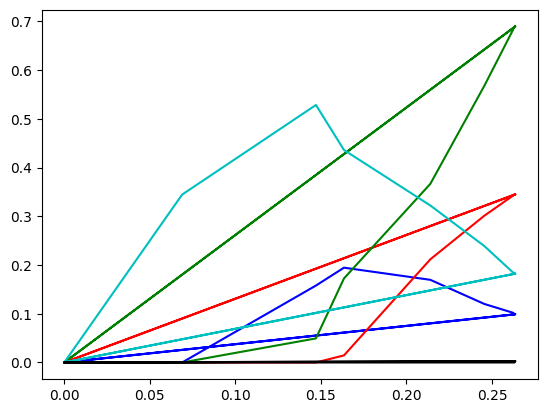

In [155]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
sd_orig = np.std(X_orig, axis=0)
print("sd_orig \n", sd_orig)
S_inv_orig = np.diag(1 / sd_orig)
#S_inv_orig = np.eye(dim)
S_inv_orig = np.array([S_inv_orig] * n_observationsss)
S_inv_orig = np.concatenate(S_inv_orig)
print("S_inv_orig.shape ", S_inv_orig.shape)
test = S_inv_orig @ np.arange(dim)
print("test mult\n", test)
print("test reshape \n", test.reshape(n_observationsss, dim, order='C'))
#print(S_inv_orig)
#S_inv_orig = np.diag(1 / sd_orig)
print("S_inv_orig shape\n ", S_inv_orig.shape)
#S_inv_orig = np.eye(X_orig.shape[0])
linfadvtrain = AdversarialTraining(X_orig, y, S_inv_orig, p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)
#plot_coefs(alphas_adv, coefs_advtrain_linf, ax)

In [ ]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(300, 8)
std_orig: 
 [1.89437779 2.6366409  2.01401922 2.72839671 3.15527389 3.08809998
 2.27970936 5.44525999]
std rf
  [1.7979924  2.55299921 1.96864074 2.63939221 3.0035545  2.98051431
 2.10802015 5.08045866]


 83%|████████▎ | 166/200 [00:12<00:18,  1.81it/s]

In [ ]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)

In [ ]:
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)


In [ ]:
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/d - 1/(d**2)) * np.diag(np.diag(S_ellp)) + 1/(d**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)


In [ ]:
# mi bayesian ridge

number_multiple_imputed_datasets = 5
X_mi = np.vstack(multiple_imputation(number_multiple_imputed_datasets, X_nan))
sd_mi = np.std(X_mi, axis=0)
print("std_orig: \n", np.std(X_orig, axis=0))
print("sd_mi\n ", sd_mi)
S_inv_mi = np.diag(1 / sd_mi)
yy = np.concatenate([y] * number_multiple_imputed_datasets)

fig, ax = plt.subplots(num='advtrain_linf_mi')
linfadvtrain_mi = AdversarialTraining(X_mi, yy, S_inv_mi, p=np.inf)
estimator_mi = lambda X, y, a:  linfadvtrain_mi(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mi  = get_path(X_mi, yy, estimator_mi, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mi, ax)





In [ ]:
Observations:

-) If the data are np.random.randn(), all the graphs looks similar
-) very caotic results if we multiply by a cov matrix


In [113]:
def compute_q1(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining1:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        print("ADV TRAINING COPY")
        # Formulate problem
        param = cp.Variable(n)
        print("shape param ", param.shape)
        print("dim ", n)
        print("shape  inv matrix ", S_inv.shape)
        #print(S_inv @ param, "weeeeeee", (S_inv @ param).shape)
        partial = S_inv @ param  # should be (m * n,)
        print("shape partial ", partial.shape)
        #partial = cp.reshape(partial, (m, n))
        #param_norm = cp.pnorm(partial, p=q, axis=1)
        param_norm = cp.pnorm(S_inv @ param, p=q)
        print("param_norm shapeeeee", param_norm.shape)
        print("param_norm + shapeeeee", param_norm)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        print("ciao2")
        abs_error = cp.abs(X @ param - y)
        print("shape abs error ", abs_error.shape)
        print("ciao3")
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        print("ciao4")
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path1(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path1(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        #print("alpha  ", a)
        coefs = estimator(X, y, a)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs1(alphas, coefs, ax):
    print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm1(coefs, ax):
    print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    #print("coef ", coefs)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data


#M = np.sum(masks, axis=1)
#X_nan = X.copy()
#X_nan[masks == 1] = np.nan

#X = multiple_imputation(1, X_nan)
print("end block")


end block


sd_orig 
 [0.24387451 0.30860921 0.28553201 0.28838746 0.30066703]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
orig shape
  (5, 5)
ADV TRAINING COPY
shape param  (5,)
dim  5
shape  inv matrix  (5, 5)
shape partial  (5,)
param_norm shapeeeee ()
param_norm + shapeeeee norm1([[1.00 0.00 ... 0.00 0.00]
 [0.00 1.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 1.00 0.00]
 [0.00 0.00 ... 0.00 1.00]] @ var2596)
ciao2
shape abs error  (20,)
ciao3
ciao4


 94%|█████████▍| 188/200 [00:04<00:00, 26.25it/s]/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:05<00:00, 34.45it/s]

you are printing coeff in function of l1 norm


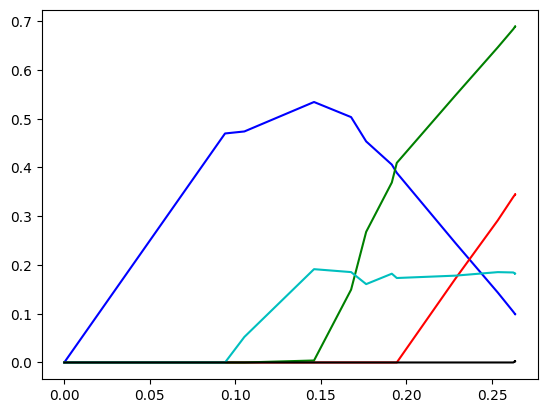

In [115]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf1')
sd_orig = np.std(X_orig, axis=0)
print("sd_orig \n", sd_orig)
S_inv_orig = np.diag(1 / sd_orig)
S_inv_orig = np.eye(dim)
#S_inv_orig = np.array([S_inv_orig] * n_observationsss)
#S_inv_orig = np.concatenate(S_inv_orig)
print(S_inv_orig)
#S_inv_orig = np.diag(1 / sd_orig)
print("orig shape\n ", S_inv_orig.shape)
#S_inv_orig = np.eye(X_orig.shape[0])
linfadvtrain1 = AdversarialTraining1(X_orig, y, S_inv_orig, p=np.inf)
estimator1 = lambda X, y, a:  linfadvtrain1(adv_radius=a)
alphas_adv1, coefs_advtrain_linf1  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm1(coefs_advtrain_linf1, ax)
#plot_coefs(alphas_adv, coefs_advtrain_linf, ax)

In [142]:
x = np.random.randint(1, 10, size=10)
print(x)
print(np.reshape(x, (2, 5), order='C'))

[7 4 1 5 3 8 5 7 3 8]
[[7 4 1 5 3]
 [8 5 7 3 8]]
